In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import spacy
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

train_df = pd.read_csv("/content/drive/My Drive/SEM-7-Documents/Final-Year-Project/DataSet2/train.csv")
test_df = pd.read_csv("/content/drive/My Drive/SEM-7-Documents/Final-Year-Project/DataSet2/test.csv")

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
#function for removing a pattern
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

nlp = spacy.load("en_core_web_sm")
def clean_text(df, text_field):
    #preprocess the data
    #Create a new column in the DataFrame of text that does not include stop words, numbers, or characters
    df['text_clean'] = df[text_field].apply(lambda elem: ' '.join([token.lemma_ for token in nlp(elem) if not token.is_stop and token.is_alpha]))
    #convert all words to lower case
    df['text_clean'] = df['text_clean'].str.lower()
    #remove amp
    df['text_clean'] = np.vectorize(remove_pattern)(df['text_clean'], "amp*")
    #remove https
    df['text_clean']= np.vectorize(remove_pattern)(df['text_clean'],"https*")
    return df

train_df = clean_text(train_df, 'text')
test_df = clean_text(test_df, 'text')
train_df.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,get send photo ruby alaska smoke wildfire pour...


In [22]:
#what proportion of tweets are disaster tweets?
np.mean(train_df['target']==1)

0.4296597924602653

In [23]:
#determine how much of the data is missing by creating a new table
missing_val=pd.DataFrame({"num": train_df.isnull().sum()})
#second column is the proportion of data that's missing
missing_val["proportion"]=missing_val["num"]/train_df.count()
missing_val

,num,proportion
id,0,0.000000
keyword,61,0.008077
location,2533,0.498622
text,0,0.000000
target,0,0.000000
text_clean,0,0.000000


In [24]:
#how many unique keywords are there?
rows=train_df['keyword'].notnull() #avoid the missing data
keywords=np.unique(train_df['keyword'][rows])
keywords.shape

(221,)

In [25]:
keywords

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'derailed

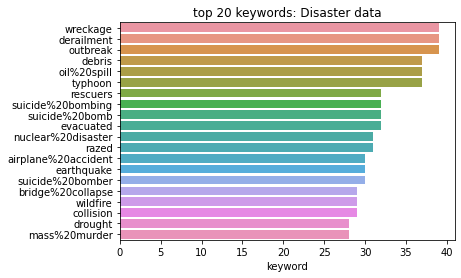

In [26]:
#what the most common keywords in the disaster data?
disaster_kw=train_df['keyword'][train_df.target==1]
#convert from words to counts and keep the top 20
disaster_kw=disaster_kw.value_counts()[0:20]
#horizontal bar plot
sns.barplot(y=disaster_kw.index,x=disaster_kw,orient='h')
plt.title('top 20 keywords: Disaster data')
plt.show()

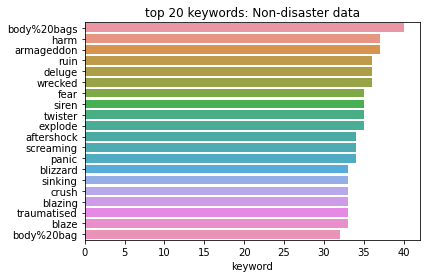

In [27]:
regular_kw=train_df['keyword'][train_df.target==0]
regular_kw=regular_kw.value_counts()[0:20]
sns.barplot(y=regular_kw.index,x=regular_kw,orient='h')
plt.title('top 20 keywords: Non-disaster data')
plt.show()

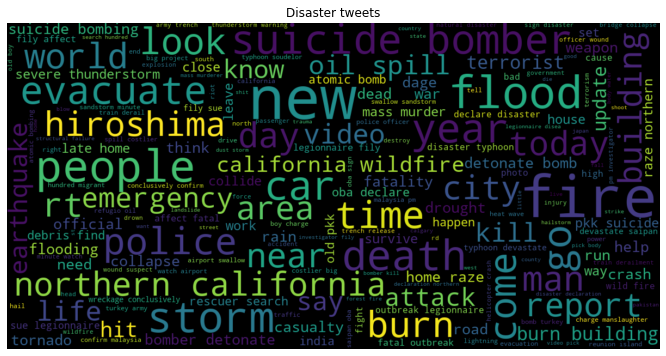

In [28]:
def show_cloud(tweets,title):
    #Create a word cloud
    #collect the disaster tweets into a single body of text
    corpus=' '.join([text for text in tweets])
    cloud=WordCloud(width=1200, height=600,max_font_size=110).generate(corpus)
    plt.figure(figsize=(12, 6)) 
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis('off') 
    plt.title(title)
    plt.show()

#query for the disaster tweets
tweets=train_df['text_clean'][train_df.target==1]
show_cloud(tweets,"Disaster tweets")

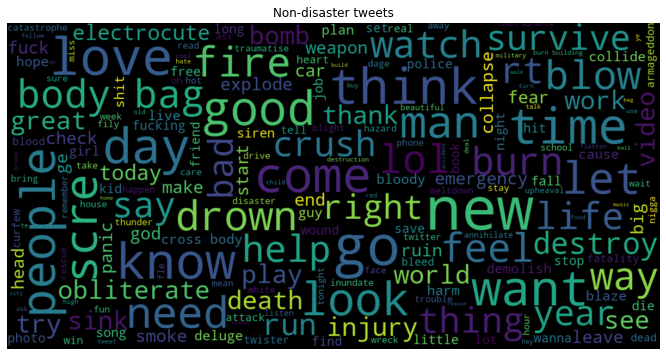

In [29]:
#collect the non-disaster tweets into a single body of text
tweets=train_df['text_clean'][train_df.target==0]
show_cloud(tweets,"Non-disaster tweets")

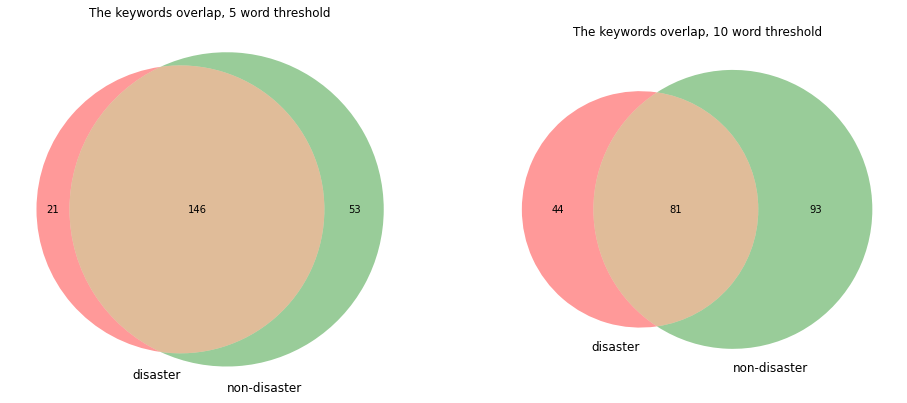

In [30]:
#to what extent do the keywords overlap between the data sets?
disaster_kw=train_df['keyword'][train_df.target==1]
#convert from words to counts
disaster_kw=disaster_kw.value_counts()
regular_kw=train_df['keyword'][train_df.target==0]
regular_kw=regular_kw.value_counts()

#use the indices to find which words are common to both sets
#a word must appear a certain # of times in each set 
th=5 #query which words appear more than 5 times
disaster_kw2=disaster_kw.index[disaster_kw>th]
regular_kw2=regular_kw.index[regular_kw>th]
intersection=np.intersect1d(disaster_kw2,regular_kw2)
n_th5=(len(disaster_kw2)-len(intersection),len(regular_kw2)-len(intersection),len(intersection))
th=10 #higher threshold
disaster_kw2=disaster_kw.index[disaster_kw>th]
regular_kw2=regular_kw.index[regular_kw>th]
intersection=np.intersect1d(disaster_kw2,regular_kw2)
n_th10=(len(disaster_kw2)-len(intersection),len(regular_kw2)-len(intersection),len(intersection))
#show a venn diagram
fig, ax=plt.subplots(1,2, figsize=(16,8))
venn2(subsets=n_th5,set_labels=('disaster','non-disaster'),ax=ax[0])
venn2(subsets=n_th10,set_labels=('disaster','non-disaster'),ax=ax[1])
ax[0].set_title('The keywords overlap, 5 word threshold')
ax[1].set_title('The keywords overlap, 10 word threshold')
plt.show()

In [31]:
#combine the keywords with the tweets
train_df['combined']=train_df['keyword'].fillna("")+' '+train_df['text']
train_df['combined_clean']=train_df['keyword'].fillna("")+' '+train_df['text_clean']
test_df['combined']=test_df['keyword'].fillna("")+' '+test_df['text']
test_df['combined_clean']=test_df['keyword'].fillna("")+' '+test_df['text_clean']

# instantiate a vectorizer that ignores frequent words such as "is" and "the"
tfidf_vectorizer=feature_extraction.text.TfidfVectorizer(analyzer='word',stop_words='english')
#simpler vectorizer
count_vectorizer = feature_extraction.text.CountVectorizer()
#create a dictionary with 4 sets of vectors
training_vect={
    'tfidf':tfidf_vectorizer.fit_transform(train_df["text"]),
    'with_kw':tfidf_vectorizer.fit_transform(train_df["combined"]),
    'clean':count_vectorizer.fit_transform(train_df["text_clean"]),
    'clean_with_kw':count_vectorizer.fit_transform(train_df["combined_clean"])
}

In [32]:
y=train_df["target"]
scoring=["accuracy","f1"];
#initialize arrays
data_column=[]
acc=[]
f1=[]
models=[MultinomialNB(), svm.LinearSVC(), linear_model.LogisticRegression()]
#for each data set in the dict
for key, X in training_vect.items(): 
    for clf in models: #for each model
        # input the model type, the features, the target vector
        scores = model_selection.cross_validate(clf, X, y, cv=8, scoring=scoring)
        # store the average accuracy and f1 score
        acc.append(scores['test_accuracy'].mean())
        f1.append(scores['test_f1'].mean())
        #populate the data column
        data_column.append(key)

performance=pd.DataFrame({
    "data" : data_column,
    "model": ['naive bayes','SVM','logistic']*4,
    "accuracy": acc,
    "f1":f1
    
})
performance.sort_values('f1',ascending=False)

,data,model,accuracy,f1
6,clean,naive bayes,0.689236,0.665847
0,tfidf,naive bayes,0.712613,0.633339
9,clean_with_kw,naive bayes,0.610169,0.608882
1,tfidf,SVM,0.677416,0.597027
8,clean,logistic,0.673212,0.592998
3,with_kw,naive bayes,0.656925,0.589515
2,tfidf,logistic,0.707225,0.581440
7,clean,SVM,0.641948,0.580184
4,with_kw,SVM,0.613978,0.546679
11,clean_with_kw,logistic,0.606097,0.528297


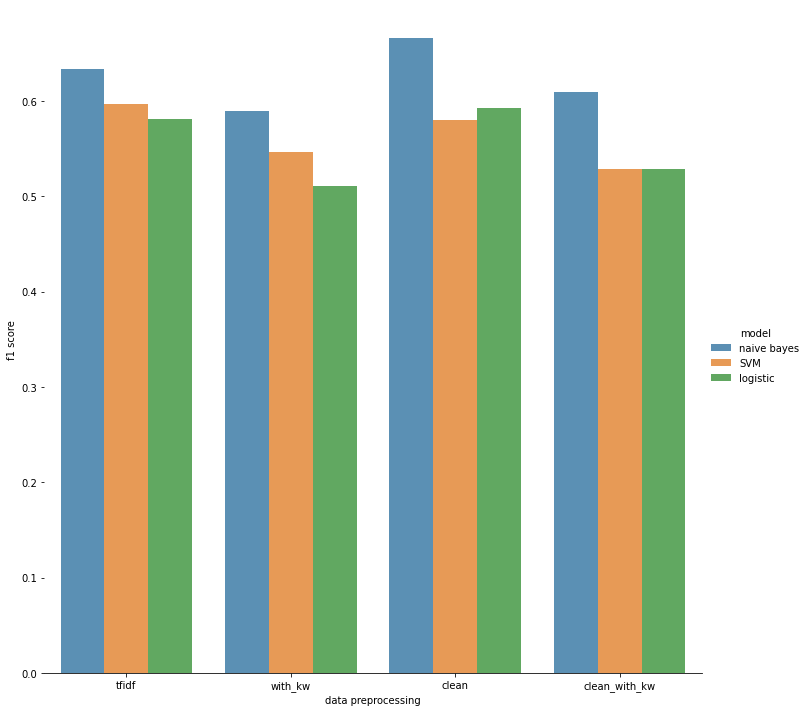

In [33]:
# Draw a nested barplot of all the f1 scores
g = sns.catplot(
    data=performance, kind="bar",
    x="data", y="f1", hue="model", 
    alpha=0.8, height=10
)
g.despine(left=True)
g.set_axis_labels("data preprocessing", "f1 score")
plt.show()

In [34]:
field="text_clean" #choose the best version of the data
#revectorize the training data to apply the same tokens to the test data
train_vectors =count_vectorizer.fit_transform(train_df[field])
# the object will store the "fit" of tokens after .fit() or .fit_transform()
# i.e. that the train and test vectors use the same set of tokens.
test_vectors =count_vectorizer.transform(test_df[field])
#use naive bayes classifier
clf=MultinomialNB();
clf.fit(train_vectors, train_df["target"])
#load the sample
sample_submission = pd.read_csv("/content/drive/My Drive/SEM-7-Documents/Final-Year-Project/DataSet/sample_submission.csv")
#put our predictions into the DataFrame
sample_submission["target"] = clf.predict(test_vectors)
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [35]:
sample_submission.to_csv("submission.csv", index=False)